# ADS-508-01-SP23 Team 8: Final Project

# Setup Database and Athena Tables

Much of the code is modified from `Fregly, C., & Barth, A. (2021). Data science on AWS: Implementing end-to-end, continuous AI and machine learning pipelines. O’Reilly.`

## Import PyAthena

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [2]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0

In [3]:
import boto3
from botocore.client import ClientError
import sagemaker
import pandas as pd
from pyathena import connect
from IPython.core.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
def_bucket = sagemaker_session.default_bucket()
bucket = 'sagemaker-us-east-ads508-sp23-t8'
role = sagemaker.get_execution_role()

s3 = boto3.Session().client(service_name="s3", region_name=region)

In [5]:
print(f"Default bucket: {def_bucket}")
print(f"Public T8 bucket: {bucket}")

Default bucket: sagemaker-us-east-1-657724983756
Public T8 bucket: sagemaker-us-east-ads508-sp23-t8


s3_conn = boto3.resource('s3')
bucket_conn = s3_conn.Bucket(bucket)

# List the contents of the bucket
for obj in bucket_conn.objects.all():
    print(obj.key)

In [6]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = f"s3://{bucket}/athena/staging"
print(s3_staging_dir)

s3://sagemaker-us-east-ads508-sp23-t8/athena/staging


In [7]:
conn = connect(region_name=region,
               s3_staging_dir=s3_staging_dir)

In [8]:
database_name = "ads508_t8"

## Query DB table - `census`

In [9]:
cen_tsv_tbl_name = 'census'

In [10]:
cen_bourough01 = "bronx"

cen_select_borough_stmnt01 = f"""
    SELECT * FROM {database_name}.{cen_tsv_tbl_name}
    WHERE lower(borough) = '{cen_bourough01}'
    LIMIT 17
    """

print(cen_select_borough_stmnt01)

cen_df01_s01 = pd.read_sql(cen_select_borough_stmnt01,
                           conn)
cen_df01_s01.head(17)


    SELECT * FROM ads508_t8.census
    WHERE lower(borough) = 'bronx'
    LIMIT 17
    


,censustract,county,borough,totalpop,men,women,hispanic,white,black,native,...,walk,othertransp,workathome,meancommute,employed,privatework,publicwork,selfemployed,familywork,unemployment
0,36005000100,Bronx,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
5,36005002000,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
6,36005002300,Bronx,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
7,36005002400,Bronx,Bronx,150,109,41,0.0,52.0,48.0,0.0,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
8,36005002500,Bronx,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
9,36005002701,Bronx,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2


In [11]:
cen_select_hispanic_stmnt01 = f"""
    SELECT DISTINCT
        hispanic,
        count(*)
    FROM {database_name}.{cen_tsv_tbl_name}
    WHERE hispanic IS NULL
    GROUP BY hispanic
    LIMIT 10
    """

print(cen_select_hispanic_stmnt01)

cen_df01_s03 = pd.read_sql(cen_select_hispanic_stmnt01,
                           conn)
cen_df01_s03.head(100)


    SELECT DISTINCT
        hispanic,
        count(*)
    FROM ads508_t8.census
    WHERE hispanic IS NULL
    GROUP BY hispanic
    LIMIT 10
    


,hispanic,_col1
0,None,39


In [12]:
cen_summ_borough_stmnt01 = f"""
    SELECT
        borough,
        COUNT(*) AS ctract_count,
        SUM(totalpop) AS bor_pop,
        SUM(round(totalpop*hispanic/100,0))/SUM(totalpop) AS hispanic_perc,
        SUM(round(totalpop*white/100,0))/SUM(totalpop) AS white_perc,
        SUM(round(totalpop*black/100,0))/SUM(totalpop) AS black_perc,
        SUM(round(totalpop*native/100,0))/SUM(totalpop) AS native_perc,
        SUM(round(totalpop*asian/100,0))/SUM(totalpop) AS asian_perc,
        SUM(round(totalpop*childpoverty/100,0))/SUM(totalpop) AS child_poverty_perc,
        SUM(round(totalpop*income,0))/SUM(totalpop) AS income_avg
    FROM {database_name}.{cen_tsv_tbl_name}
    GROUP BY borough
    LIMIT 100
    """

print(cen_summ_borough_stmnt01)

cen_df01_s02 = pd.read_sql(cen_summ_borough_stmnt01,
                           conn)
cen_df01_s02.head(17)


    SELECT
        borough,
        COUNT(*) AS ctract_count,
        SUM(totalpop) AS bor_pop,
        SUM(round(totalpop*hispanic/100,0))/SUM(totalpop) AS hispanic_perc,
        SUM(round(totalpop*white/100,0))/SUM(totalpop) AS white_perc,
        SUM(round(totalpop*black/100,0))/SUM(totalpop) AS black_perc,
        SUM(round(totalpop*native/100,0))/SUM(totalpop) AS native_perc,
        SUM(round(totalpop*asian/100,0))/SUM(totalpop) AS asian_perc,
        SUM(round(totalpop*childpoverty/100,0))/SUM(totalpop) AS child_poverty_perc,
        SUM(round(totalpop*income,0))/SUM(totalpop) AS income_avg
    FROM ads508_t8.census
    GROUP BY borough
    LIMIT 100
    


,borough,ctract_count,bor_pop,hispanic_perc,white_perc,black_perc,native_perc,asian_perc,child_poverty_perc,income_avg
0,Brooklyn,761,2595259,0.196219,0.357155,0.311851,0.001728,0.114031,0.293884,51694
1,Queens,669,2301139,0.279454,0.261341,0.173913,0.002189,0.242256,0.195747,59851
2,Manhattan,288,1629507,0.257999,0.471131,0.127395,0.001357,0.115712,0.198270,78003
3,Staten Island,110,472481,0.178469,0.628205,0.095900,0.001179,0.079440,0.155067,73993
4,Bronx,339,1428357,0.546306,0.102867,0.295901,0.002247,0.035982,0.394679,36822


In [13]:
cen_summ_borough_stmnt01 = f"""
    SELECT
        censustract,
        COUNT(*) AS ctract_count,
        SUM(totalpop) AS bor_pop,
        SUM(round(totalpop*hispanic/100,0))/SUM(totalpop) AS hispanic_perc,
        SUM(round(totalpop*white/100,0))/SUM(totalpop) AS white_perc,
        SUM(round(totalpop*black/100,0))/SUM(totalpop) AS black_perc,
        SUM(round(totalpop*native/100,0))/SUM(totalpop) AS native_perc,
        SUM(round(totalpop*asian/100,0))/SUM(totalpop) AS asian_perc,
        SUM(round(totalpop*childpoverty/100,0))/SUM(totalpop) AS child_poverty_perc,
        SUM(round(totalpop*income,0))/SUM(totalpop) AS income_avg
    FROM {database_name}.{cen_tsv_tbl_name}
    GROUP BY censustract
    LIMIT 100
    """

print(cen_summ_borough_stmnt01)

cen_df01_s02 = pd.read_sql(cen_summ_borough_stmnt01,
                           conn)
cen_df01_s02.head(17)


    SELECT
        censustract,
        COUNT(*) AS ctract_count,
        SUM(totalpop) AS bor_pop,
        SUM(round(totalpop*hispanic/100,0))/SUM(totalpop) AS hispanic_perc,
        SUM(round(totalpop*white/100,0))/SUM(totalpop) AS white_perc,
        SUM(round(totalpop*black/100,0))/SUM(totalpop) AS black_perc,
        SUM(round(totalpop*native/100,0))/SUM(totalpop) AS native_perc,
        SUM(round(totalpop*asian/100,0))/SUM(totalpop) AS asian_perc,
        SUM(round(totalpop*childpoverty/100,0))/SUM(totalpop) AS child_poverty_perc,
        SUM(round(totalpop*income,0))/SUM(totalpop) AS income_avg
    FROM ads508_t8.census
    GROUP BY censustract
    LIMIT 100
    


,censustract,ctract_count,bor_pop,hispanic_perc,white_perc,black_perc,native_perc,asian_perc,child_poverty_perc,income_avg
0,36005000200,1,5403,0.757912,0.022950,0.159911,0.000000,0.042014,0.206922,72034
1,36005001900,1,2591,0.553840,0.089927,0.289849,0.000000,0.020841,0.314936,37936
2,36005003100,1,1466,0.723056,0.006139,0.246248,0.000000,0.021828,0.251705,37250
3,36005004001,1,1419,0.513037,0.112051,0.107822,0.000000,0.216350,0.286117,48056
4,36005005200,1,2277,0.696970,0.004831,0.267018,0.000000,0.028986,0.577953,17756
5,36005006000,1,1256,0.694268,0.040605,0.214172,0.000000,0.018312,0.468153,41190
6,36005009200,1,5622,0.609036,0.027926,0.141942,0.000000,0.178051,0.281928,35227
7,36005009300,1,6517,0.725948,0.011969,0.257941,0.001074,0.000000,0.497008,30159
8,36005012101,1,3057,0.727838,0.034020,0.217861,0.000000,0.011122,0.485116,27813
9,36005013300,1,7284,0.697968,0.010022,0.288029,0.000000,0.000000,0.264003,25282


In [14]:
cen_box_stmnt01 = f"""
    SELECT
        borough,
        totalpop,
        men,
        women,
        hispanic,
        white,
        black,
        native,
        asian,
        citizen,
        income,
        poverty,
        childpoverty,
        professional,
        service,
        office,
        construction,
        production,
        drive,
        carpool,
        transit,
        walk,
        othertransp,
        workathome,
        meancommute,
        employed int,
        privatework,
        publicwork,
        selfemployed,
        familywork,
        unemployment
    FROM {database_name}.{cen_tsv_tbl_name}
    LIMIT 5000
    """

print(cen_box_stmnt01)

cen_df01_s04 = pd.read_sql(cen_box_stmnt01,
                           conn)
cen_df01_s04.head(17)


    SELECT
        borough,
        totalpop,
        men,
        women,
        hispanic,
        white,
        black,
        native,
        asian,
        citizen,
        income,
        poverty,
        childpoverty,
        professional,
        service,
        office,
        construction,
        production,
        drive,
        carpool,
        transit,
        walk,
        othertransp,
        workathome,
        meancommute,
        employed int,
        privatework,
        publicwork,
        selfemployed,
        familywork,
        unemployment
    FROM ads508_t8.census
    LIMIT 5000
    


,borough,totalpop,men,women,hispanic,white,black,native,asian,citizen,...,walk,othertransp,workathome,meancommute,int,privatework,publicwork,selfemployed,familywork,unemployment
0,Bronx,7703,7133,570,29.9,6.1,60.9,0.2,1.6,6476,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,4.2,3639,...,2.9,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7
2,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,0.3,4100,...,1.4,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5
3,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,0.0,3536,...,8.6,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7
4,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,2.1,1557,...,3.0,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2
5,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,3.3,5436,...,4.3,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2
6,Bronx,4774,2130,2644,62.3,0.2,36.5,1.0,0.0,3056,...,14.0,1.5,4.1,42.7,1191,74.2,16.1,9.7,0.0,18.9
7,Bronx,150,109,41,0.0,52.0,48.0,0.0,0.0,41,...,0.0,0.0,0.0,NaN,113,62.8,37.2,0.0,0.0,0.0
8,Bronx,5355,2338,3017,76.5,1.5,18.9,0.0,3.0,2509,...,17.7,1.8,2.7,35.5,1691,85.1,8.3,6.1,0.5,9.4
9,Bronx,3016,1375,1641,68.0,0.0,31.2,0.0,0.0,1456,...,18.0,0.0,1.6,42.8,1102,86.9,8.5,4.5,0.0,15.2


# Set Seaborn Parameters

In [17]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

[Text(0.5, 1.0, 'Population of Each Census Tract by Borough')]

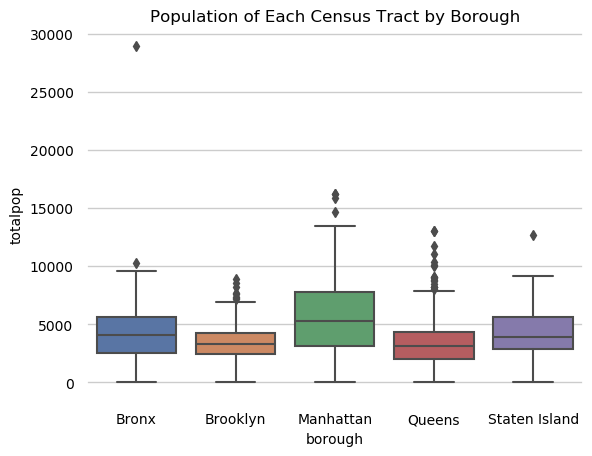

In [20]:
%matplotlib inline
sns.boxplot(x='borough', y='totalpop', data=cen_df01_s04).set(title='Population of Each Census Tract by Borough')

[Text(0.5, 1.0, 'Child Poverty (%) of Each Census Tract by Borough')]

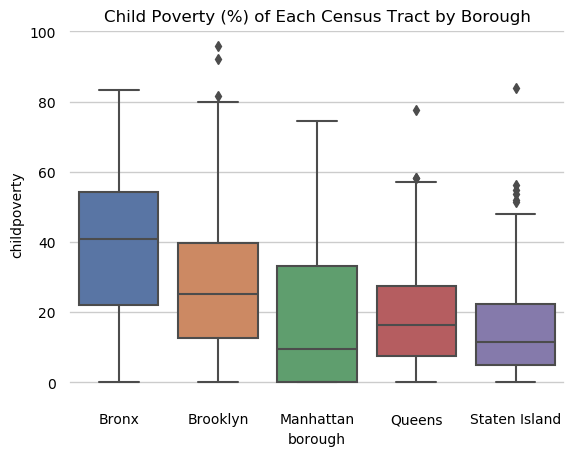

In [22]:
%matplotlib inline
sns.boxplot(x='borough', y='childpoverty', data=cen_df01_s04).set(title='Child Poverty (%) of Each Census Tract by Borough')

## Setup Output Data

In [ ]:
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

output_prefix = f"amazon-reviews-spark-analyzer-{timestamp_prefix}"
processing_job_name = f"amazon-reviews-spark-analyzer-{timestamp_prefix}"

print("Processing job name:  {}".format(processing_job_name))

In [ ]:
s3_output_analyze_data = f"s3://{bucket}/{output_prefix}/output"

print(s3_output_analyze_data)

In [ ]:
grd_tsv_s3_raw_data_path = f"s3://{bucket}/raw_data/grad_outcomes"
s3_output_analyze_data = f's3://{bucket}/{output_prefix}/output/'

from sagemaker.spark.processing import PySparkProcessor

processor = PySparkProcessor(base_job_name = 'spark-grad-outcomes-analyzer',
                             role=role,
                             framework_version='2.4',
                             instance_count=10,
                             instance_type='m4.large',
                             max_runtime_in_seconds=300)

processor.run(submit_app='preprocess-deequ-pyspark.py',
              submit_jars='deequ-1.0.3-rc2.jar',
              arguments=['grd_tsv_s3_raw_data_path', grd_tsv_s3_raw_data_path,
                         's3_output_analyze_data', s3_output_analyze_data,]
              logs=True,
              wait=False
             )

dataset = spark.read.csv(grd_tsv_s3_raw_data_path,
                         header=True,
                         schema=schema,
                         

## Release Resources

In [23]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [24]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>